In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer

In [112]:
df = pd.read_csv("../data/train.csv")
df.drop('Name', axis=1, inplace=True)
df.drop('PassengerId', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)
print(df.info())
print(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB
None
          count unique      top freq       mean        std   min     25%  \
Survived  891.0    NaN      NaN  NaN   0.383838   0.486592   0.0     0.0   
Pclass    891.0    NaN      NaN  NaN   2.308642   0.836071   1.0     2.0   
Sex         891      2     male  577        NaN        NaN   NaN     NaN   
Age       714.0    NaN      NaN  NaN  29.699118  14.526497  0.42  20.125   
SibSp     891.0    

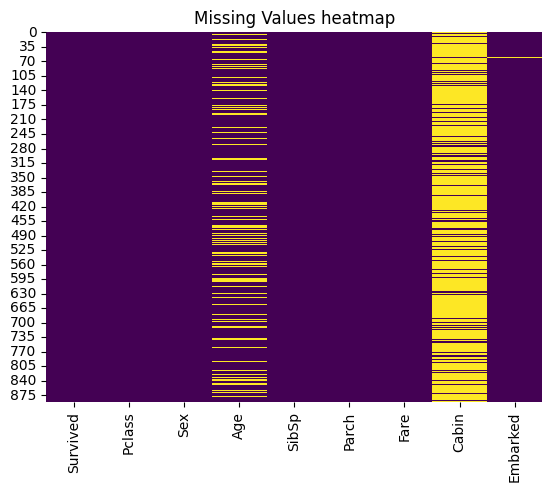

In [ ]:
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title('Missing Values heatmap')
plt.show()

In [119]:
missing_percentage = df.isnull().mean() * 100
print(missing_percentage.sort_values(ascending=False))

Cabin       77.104377
Age         19.865320
Embarked     0.224467
Survived     0.000000
Pclass       0.000000
Sex          0.000000
SibSp        0.000000
Parch        0.000000
Fare         0.000000
dtype: float64


## Let's handle Cabin missing values

In [95]:
# Count missing and total values by Pclass
missing_counts = df[df['Cabin'].isnull() | (df['Cabin'] == '')].groupby('Pclass').size()
total_counts = df['Pclass'].value_counts().sort_index()

missing_df = pd.DataFrame({'Missing_Cabin': missing_counts, 'Total': total_counts})
missing_df['Percentage_Missing'] = (missing_df['Missing_Cabin'] / missing_df['Total']) * 100

print(missing_df)

        Missing_Cabin  Total  Percentage_Missing
Pclass                                          
1                  40    216           18.518519
2                 168    184           91.304348
3                 479    491           97.556008


In [96]:
def extract_cabin_info(cabin):
    if pd.isna(cabin) or cabin == '':
        return 0, 'N'
    cabins = cabin.split()
    count = len(cabins)
    first_cabin = cabins[0]
    match = re.match(r'([A-Z])\d+', first_cabin)
    if match:
        letter = match.groups()[0]
        return count, letter
    return count, 'N'

df[['cabin_count', 'cabin_letter']] = df['Cabin'].apply(
    lambda x: pd.Series(extract_cabin_info(x))
)

df.drop('Cabin', axis=1, inplace=True)
df['cabin_letter'] = df['cabin_letter'].astype('category')
print(df)

     Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  \
0           0       3    male  22.0      1      0   7.2500        S   
1           1       1  female  38.0      1      0  71.2833        C   
2           1       3  female  26.0      0      0   7.9250        S   
3           1       1  female  35.0      1      0  53.1000        S   
4           0       3    male  35.0      0      0   8.0500        S   
..        ...     ...     ...   ...    ...    ...      ...      ...   
886         0       2    male  27.0      0      0  13.0000        S   
887         1       1  female  19.0      0      0  30.0000        S   
888         0       3  female   NaN      1      2  23.4500        S   
889         1       1    male  26.0      0      0  30.0000        C   
890         0       3    male  32.0      0      0   7.7500        Q   

     cabin_count cabin_letter  
0              0            N  
1              1            C  
2              0            N  
3              1   

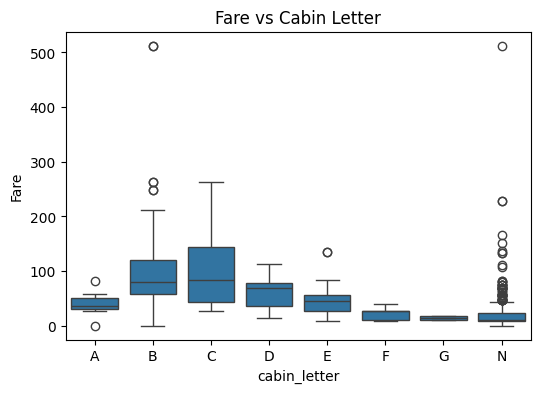

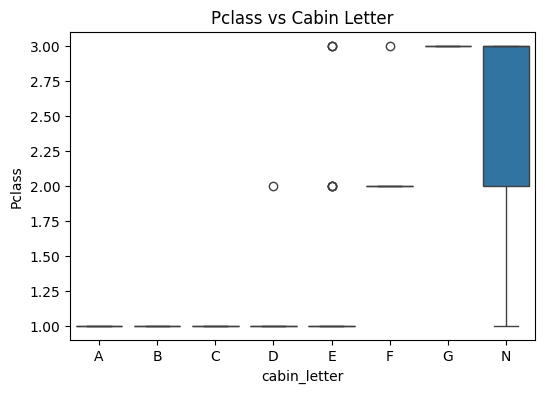

In [97]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='cabin_letter', y='Fare', data=df)
plt.title('Fare vs Cabin Letter')
plt.show()


plt.figure(figsize=(6, 4))
sns.boxplot(x='cabin_letter', y='Pclass', data=df)
plt.title('Pclass vs Cabin Letter')
plt.show()

# Let's handle Age missing values

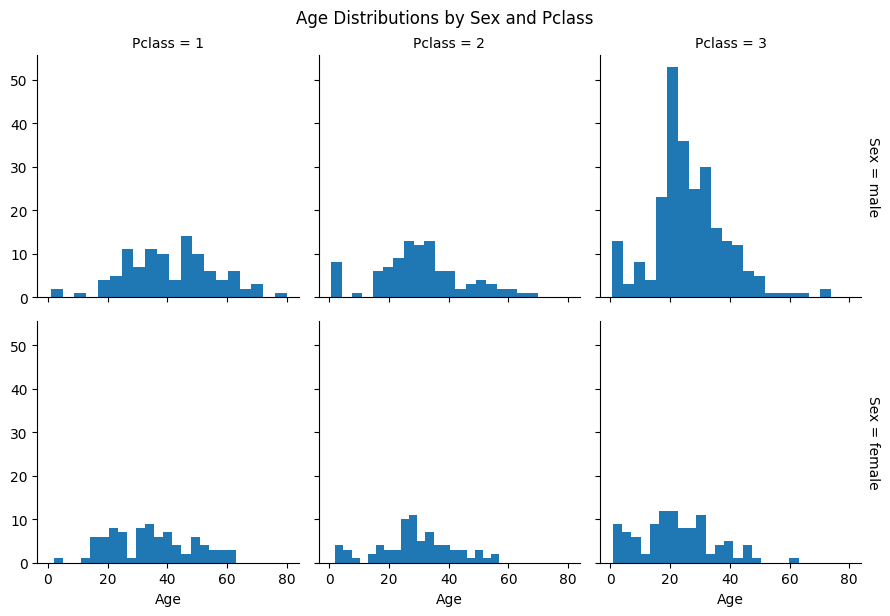

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# FacetGrid: Age distributions conditioned on Sex and Pclass
g = sns.FacetGrid(df, col="Pclass", row="Sex", margin_titles=True)
g.map(plt.hist, "Age", bins=20)
plt.suptitle("Age Distributions by Sex and Pclass", y=1.02)
plt.show()

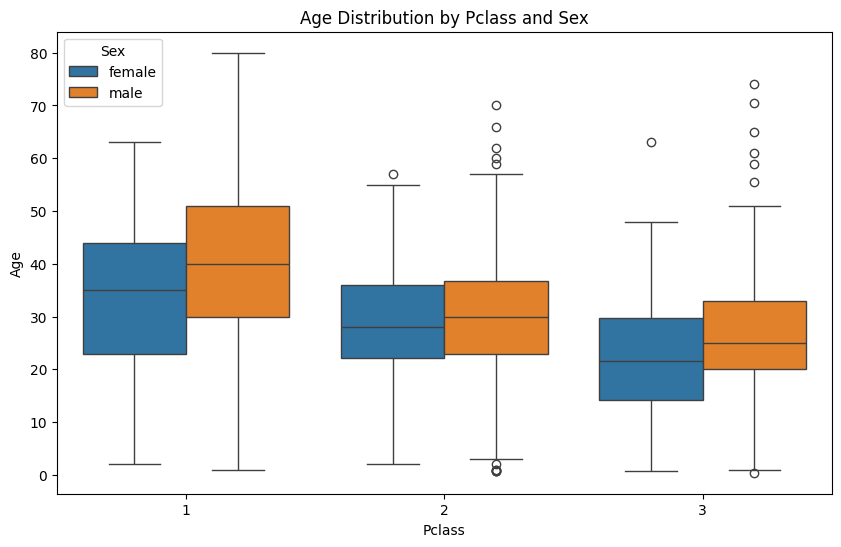

In [109]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', hue='Sex', data=df)
plt.title('Age Distribution by Pclass and Sex')
plt.show()

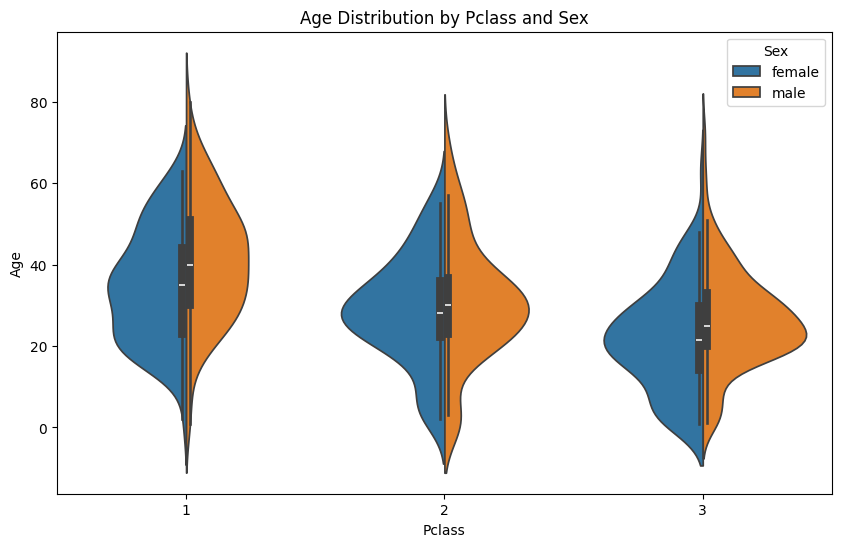

In [114]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Pclass', y='Age', hue='Sex', data=df, split=True)
plt.title('Age Distribution by Pclass and Sex')
plt.show()


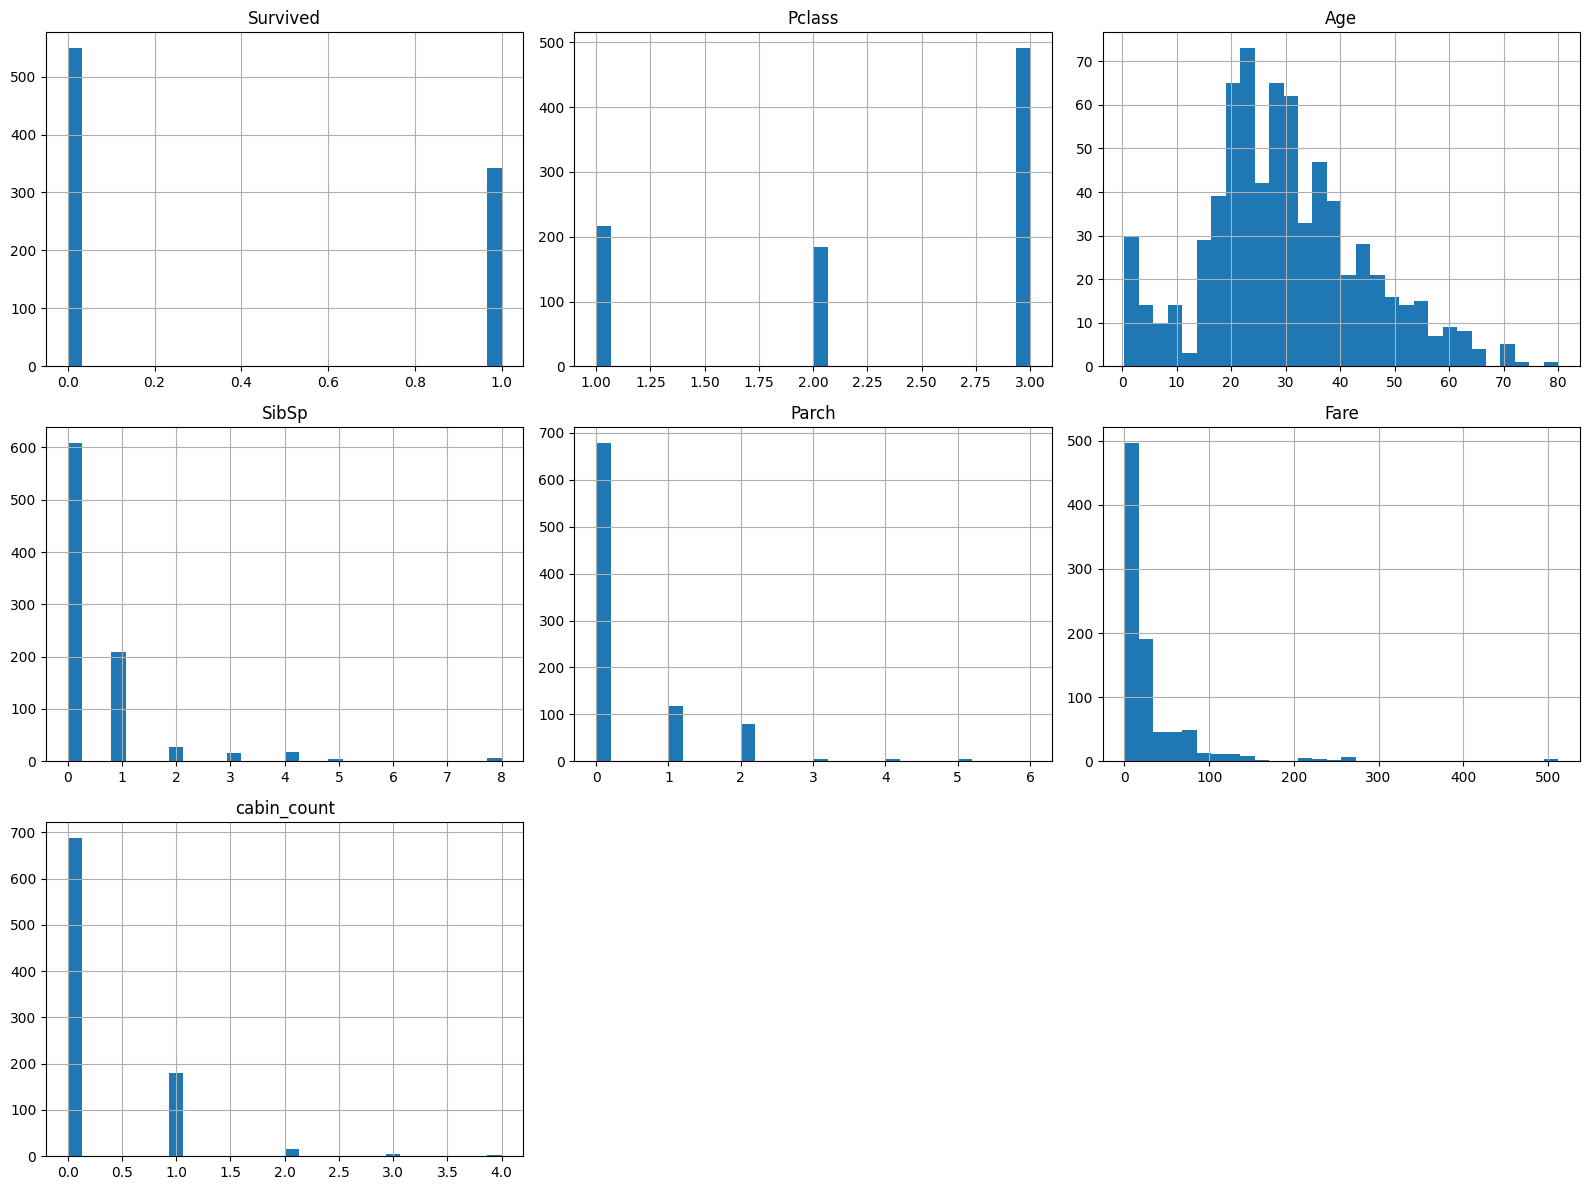

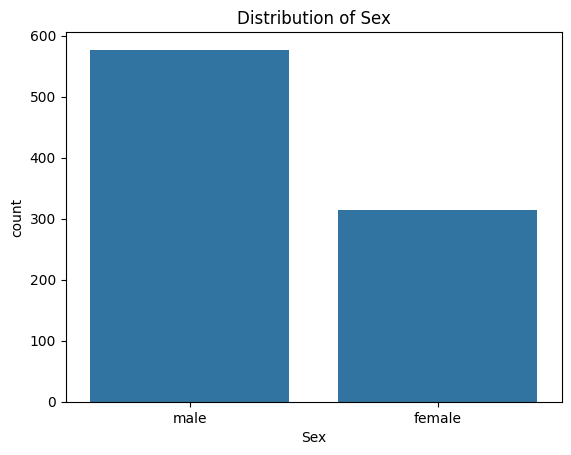

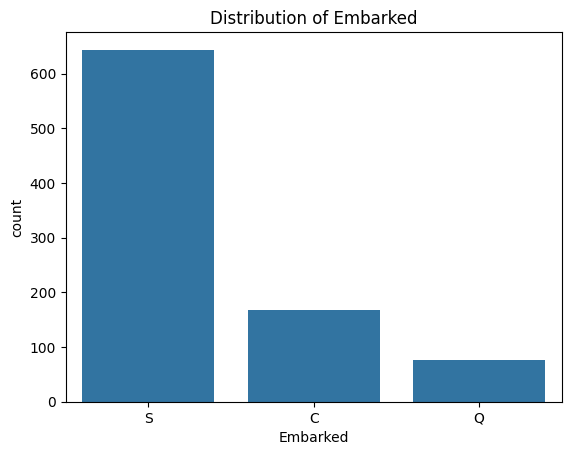

In [100]:
# Numerical
df.hist(figsize=(16,12), bins=30)
plt.tight_layout()
plt.show()

# Categorical
for col in df.select_dtypes(include='object'):
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

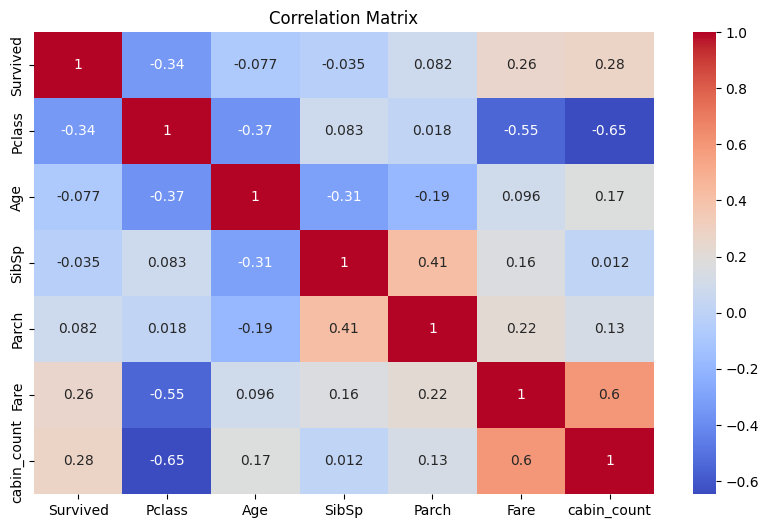

In [101]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

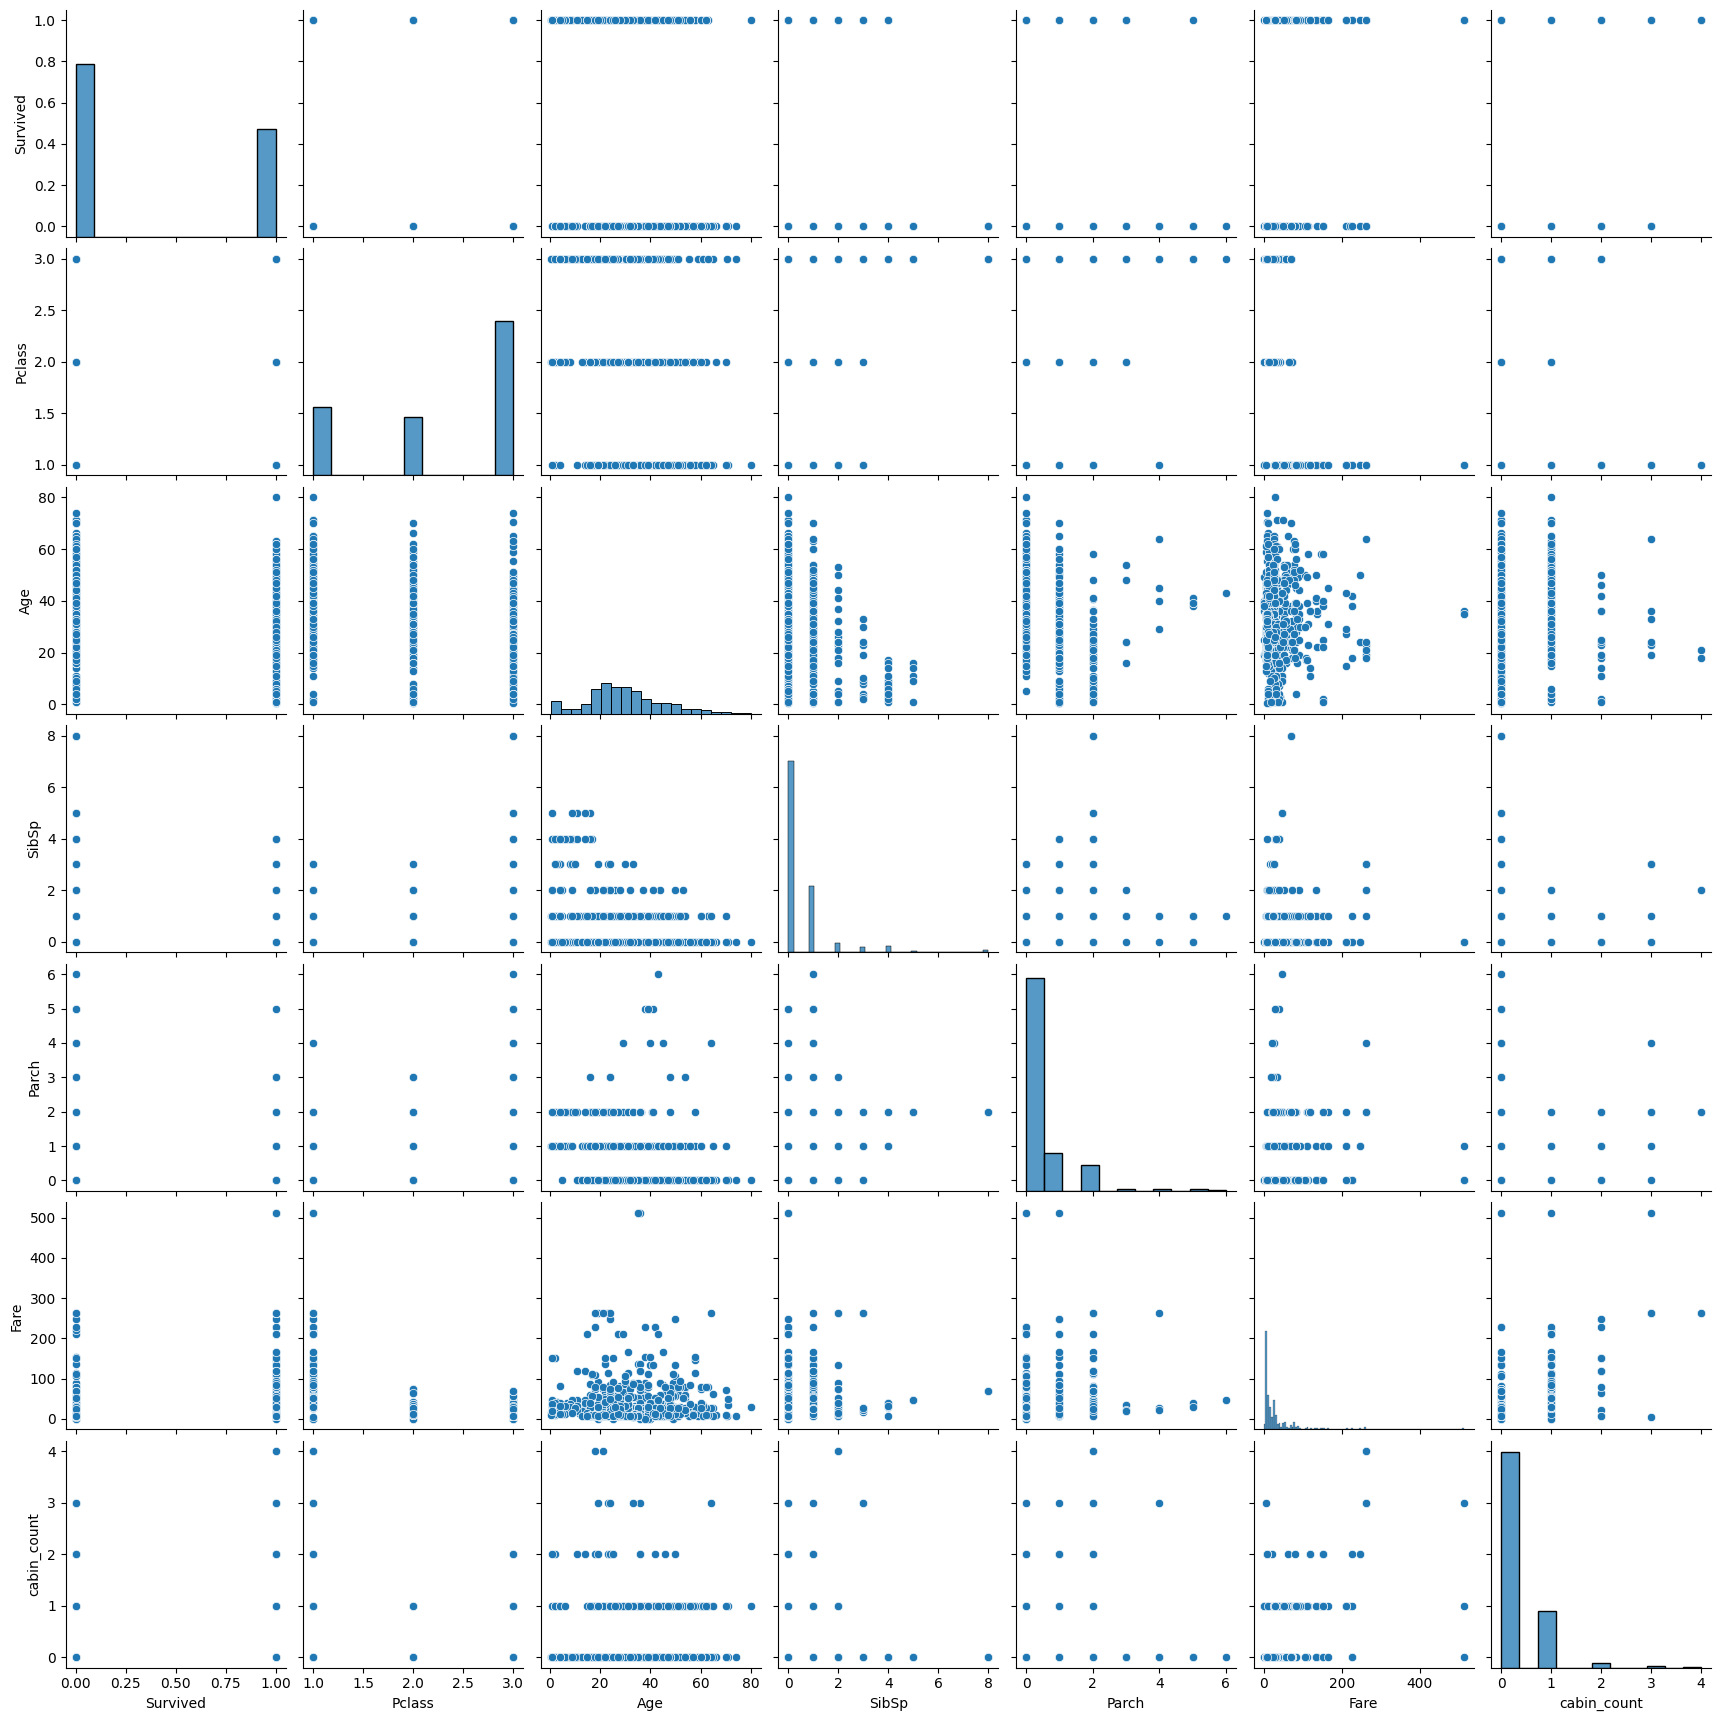

In [102]:
sns.pairplot(df)
plt.show()


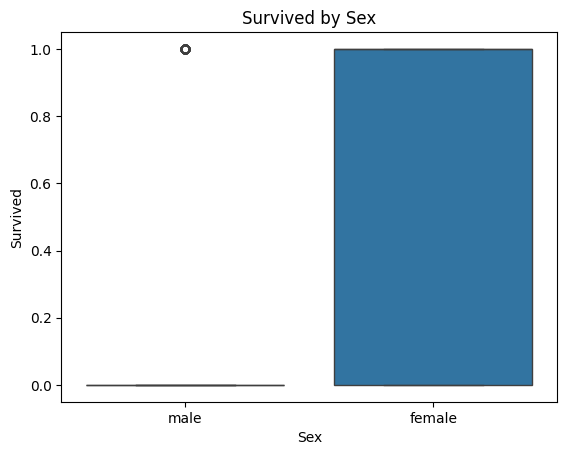

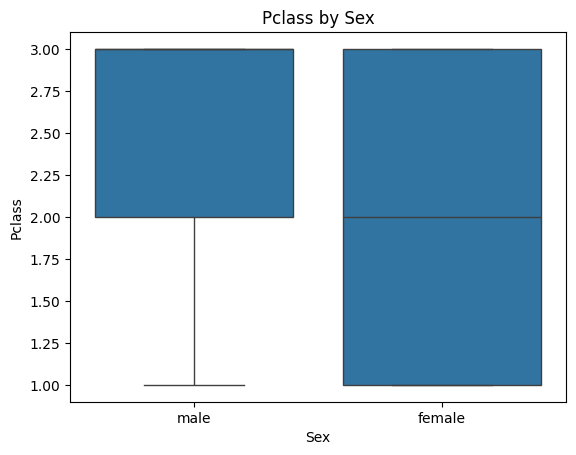

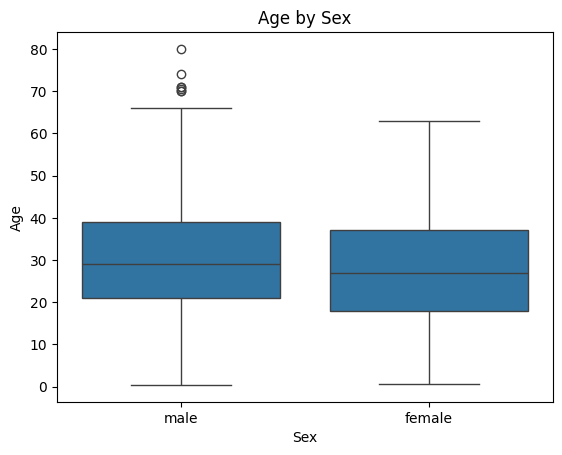

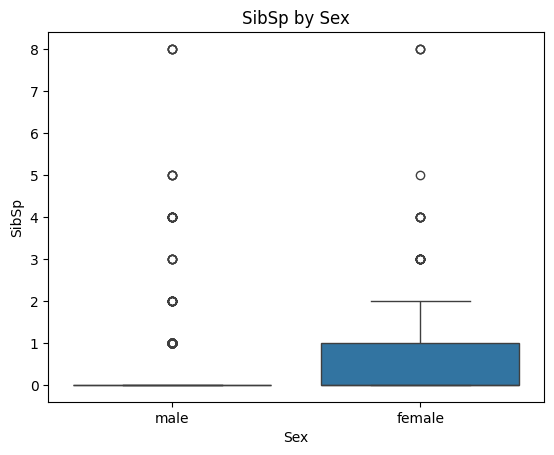

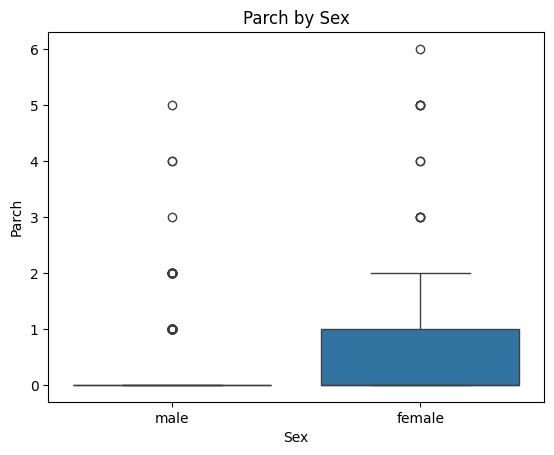

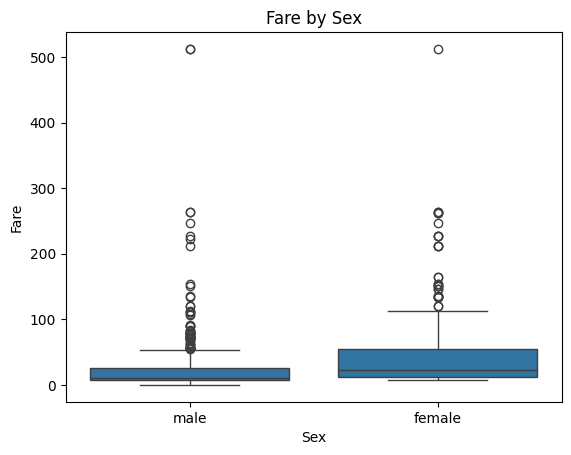

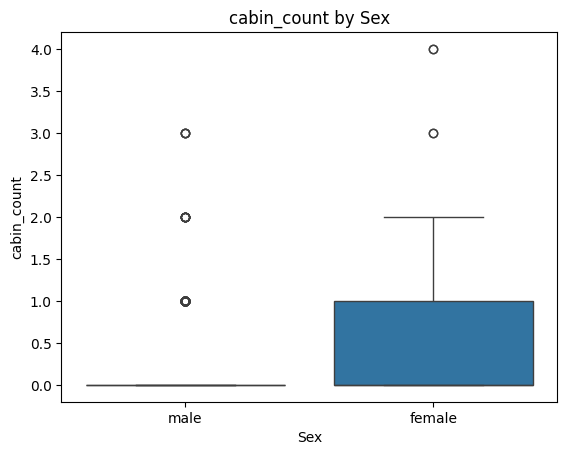

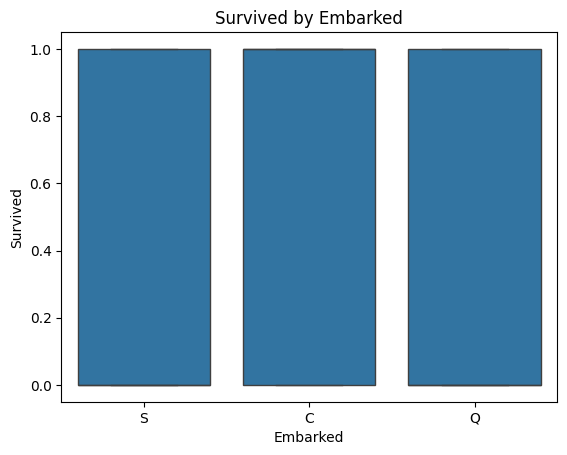

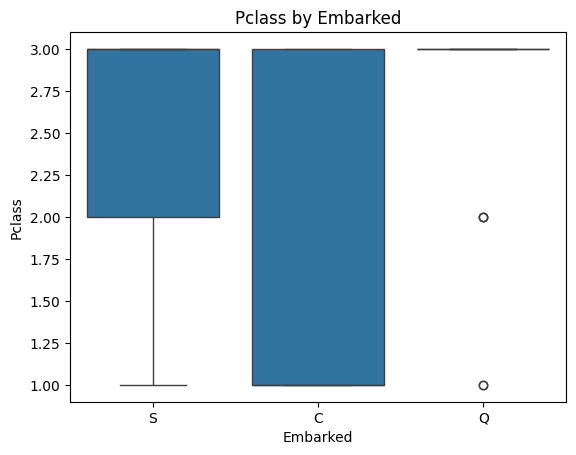

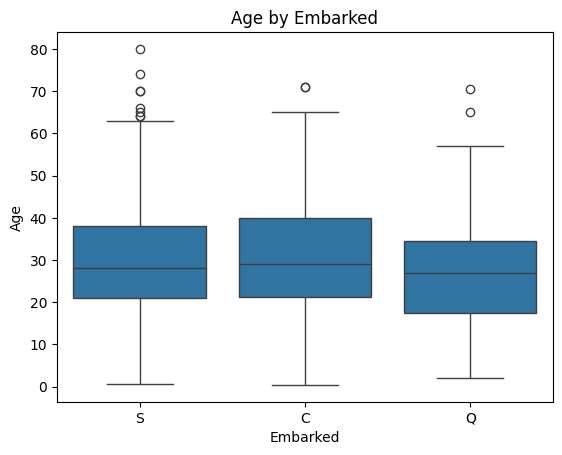

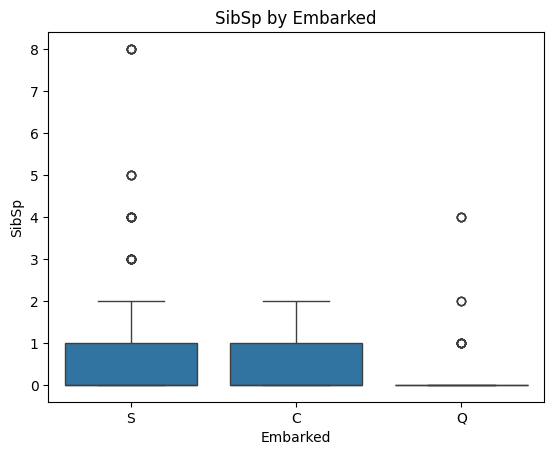

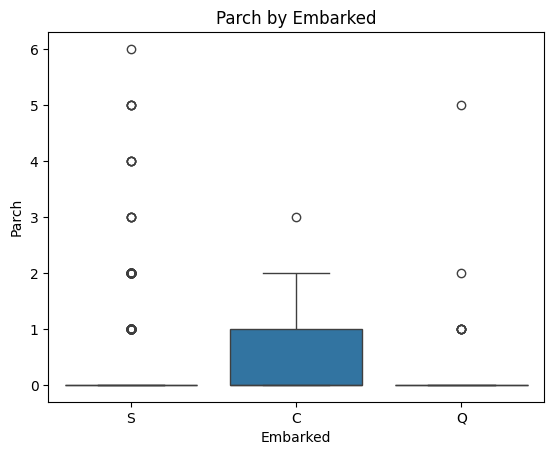

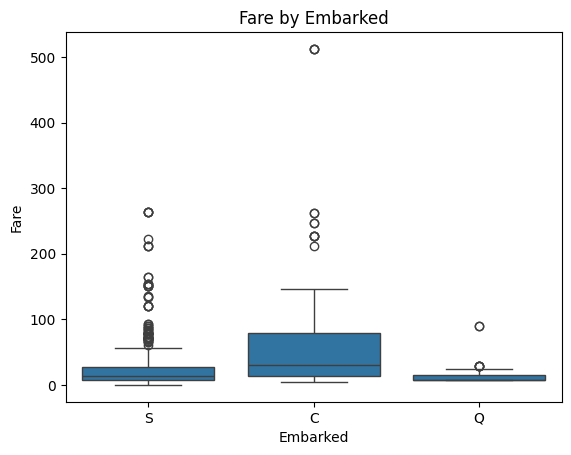

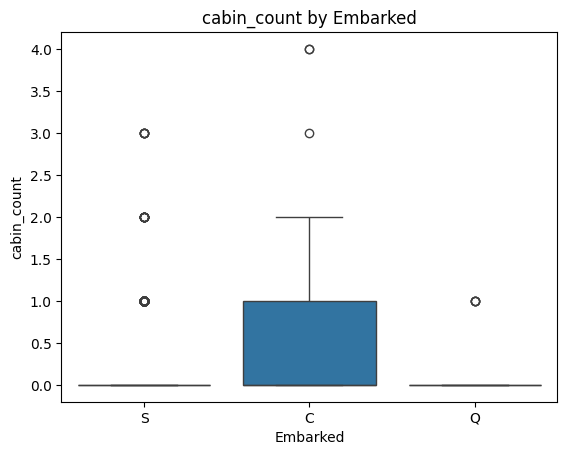

In [103]:
for col in df.select_dtypes(include='object'):
    for num_col in df.select_dtypes(include='number'):
        sns.boxplot(x=col, y=num_col, data=df)
        plt.title(f'{num_col} by {col}')
        plt.show()

In [106]:
numeric_cols = df.select_dtypes(include='number').columns
z_scores = np.abs(stats.zscore(df[numeric_cols]))
outliers = (z_scores > 3).sum()
print(outliers)

Survived        0
Pclass          0
Age             0
SibSp          30
Parch          15
Fare           20
cabin_count    24
dtype: int64


In [107]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_count,cabin_letter
0,0,3,male,22.0,1,0,7.2500,S,0,N
1,1,1,female,38.0,1,0,71.2833,C,1,C
2,1,3,female,26.0,0,0,7.9250,S,0,N
3,1,1,female,35.0,1,0,53.1000,S,1,C
4,0,3,male,35.0,0,0,8.0500,S,0,N
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,0,N
887,1,1,female,19.0,0,0,30.0000,S,1,B
888,0,3,female,NaN,1,2,23.4500,S,0,N
889,1,1,male,26.0,0,0,30.0000,C,1,C
